In [1]:
import os
import cv2
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd

In [2]:
# Mendefinisikan direktori dataset
dataset_dir = "./../dataset_nitrogen"

In [3]:
# Mengumpulkan daftar file gambar daun dan label pemupukan
image_files = []
labels = []

In [4]:
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            if image_path.endswith(".jpg"):
                image_files.append(image_path)
                labels.append(class_name)
print(labels)
print(image_files)

['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',

In [5]:
# Mengubah gambar daun menjadi fitur warna (RGB, HSV, Grayscale) dan histogram
X_rgb = []
X_hsv = []
X_gray = []
X_hist = []

In [6]:
for image_file in image_files:
    image = cv2.imread(image_file)
    resized_image = cv2.resize(image, (32, 32))  #piksel gambar

    # Penghilangan background
    mask = np.zeros(resized_image.shape[:2], dtype=np.uint8)
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    masked_image = cv2.bitwise_and(resized_image, resized_image, mask=mask)

    # Ekstraksi fitur RGB
    rgb_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
    flattened_rgb = rgb_image.flatten()
    mean_rgb = np.mean(rgb_image, axis=(0, 1))
    mode_rgb = np.argmax(np.bincount(flattened_rgb))
    median_rgb = np.median(flattened_rgb)
    X_rgb.append(np.concatenate((flattened_rgb, mean_rgb, [mode_rgb], [median_rgb])))

    # Ekstraksi fitur HSV
    hsv_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)
    flattened_hsv = hsv_image.flatten()
    mean_hsv = np.mean(hsv_image, axis=(0, 1))
    mode_hsv = np.argmax(np.bincount(flattened_hsv))
    median_hsv = np.median(flattened_hsv)
    X_hsv.append(np.concatenate((flattened_hsv, mean_hsv, [mode_hsv], [median_hsv])))

    # Ekstraksi fitur Grayscale
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    flattened_gray = gray_image.flatten()
    mean_gray = np.mean(gray_image)
    mode_gray = np.argmax(np.bincount(flattened_gray))
    median_gray = np.median(flattened_gray)
    X_gray.append(np.concatenate((flattened_gray, [mean_gray], [mode_gray], [median_gray])))

    # Ekstraksi histogram
    hist = cv2.calcHist([masked_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist_flattened = hist.flatten()
    X_hist.append(hist_flattened)

In [7]:
# Mengonversi label ke dalam bentuk numerik
label_mapping = {label: i for i, label in enumerate(set(labels))}
y = np.array([label_mapping[label] for label in labels])

print(label_mapping)

{'2': 0, '5': 1, '3': 2, '4': 3}


In [8]:
# Bagi data menjadi data latih dan data uji
X_train_rgb, X_test_rgb, y_train, y_test = train_test_split(X_rgb, y, test_size=0.2, random_state=42)
X_train_hsv, X_test_hsv, y_train, y_test = train_test_split(X_hsv, y, test_size=0.2, random_state=42)
X_train_gray, X_test_gray, y_train, y_test = train_test_split(X_gray, y, test_size=0.2, random_state=42)
X_train_hist, X_test_hist, y_train, y_test = train_test_split(X_hist, y, test_size=0.2, random_state=42)

print("Jumlah data latih (RGB):", len(X_train_rgb))
print("Jumlah data uji (RGB):", len(X_test_rgb))

print("Jumlah data latih (HSV):", len(X_train_hsv))
print("Jumlah data uji (HSV):", len(X_test_hsv))

print("Jumlah data latih (Grayscale):", len(X_train_gray))
print("Jumlah data uji (Grayscale):", len(X_test_gray))

print("Jumlah data latih (Histogram):", len(X_train_hist))
print("Jumlah data uji (Histogram):", len(X_test_hist))

Jumlah data latih (RGB): 4312
Jumlah data uji (RGB): 1078
Jumlah data latih (HSV): 4312
Jumlah data uji (HSV): 1078
Jumlah data latih (Grayscale): 4312
Jumlah data uji (Grayscale): 1078
Jumlah data latih (Histogram): 4312
Jumlah data uji (Histogram): 1078


In [9]:
# Menggabungkan fitur RGB, HSV, Grayscale, dan histogram
X_train = np.concatenate((X_train_rgb, X_train_hsv, X_train_gray, X_train_hist), axis=1)
X_test = np.concatenate((X_test_rgb, X_test_hsv, X_test_gray, X_test_hist), axis=1)

print("Dimensi data latih (X_train):", X_train.shape)
print("Dimensi data uji (X_test):", X_test.shape)

Dimensi data latih (X_train): (4312, 7693)
Dimensi data uji (X_test): (1078, 7693)


In [10]:
# Inisialisasi KNN classifier
k = 4
knn = KNeighborsClassifier(n_neighbors=k)

print("Objek KNN Classifier:", knn)

Objek KNN Classifier: KNeighborsClassifier(n_neighbors=4)


In [11]:
# Melatih model KNN
knn.fit(X_train, y_train)
print("Model KNN setelah dilatih:", knn.fit(X_train, y_train))

Model KNN setelah dilatih: KNeighborsClassifier(n_neighbors=4)


In [12]:
# Membuat dictionary untuk kustomisasi label
custom_label_mapping = {i: label for i, label in enumerate(label_mapping.keys())}
print(custom_label_mapping)

{0: '2', 1: '5', 2: '3', 3: '4'}


In [13]:
# Simpan model KNN dan kustomisasi labelnya ke dalam file .pkl
knn_model_custom = {
    "model": knn,
    "label_mapping": custom_label_mapping
}

with open("save_model/knn_model.pkl", "wb") as f:
    pickle.dump(knn_model_custom, f)

# Menyimpan model KNN ke dalam file .h5
dir_path = "save_model/"
os.makedirs(dir_path, exist_ok=True)
file_path = os.path.join(dir_path, "knn_model.h5")
joblib.dump(knn, file_path)

['save_model/knn_model.h5']

In [14]:
# Memprediksi label untuk data uji
y_pred = knn.predict(X_test)

In [15]:
# Membuat confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[267   6   0  25]
 [  1 273   0   2]
 [  0   0 239   0]
 [ 18  12   2 233]]


In [16]:
# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy*100)

Accuracy: 93.87755102040816


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       298
           1       0.94      0.99      0.96       276
           2       0.99      1.00      1.00       239
           3       0.90      0.88      0.89       265

    accuracy                           0.94      1078
   macro avg       0.94      0.94      0.94      1078
weighted avg       0.94      0.94      0.94      1078



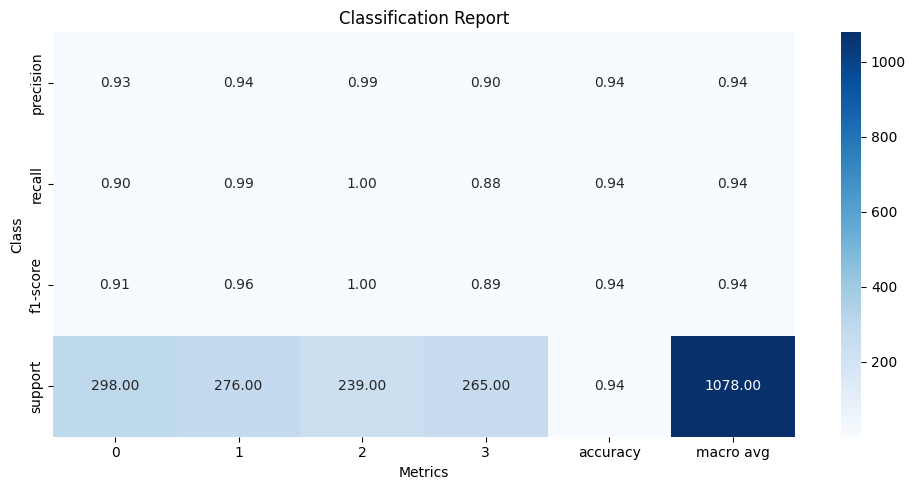

In [17]:
# Membuat classification report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

cr = classification_report(y_test, y_pred, output_dict=True)
df_classification_rep = pd.DataFrame(cr).transpose()

# Plotting classification report
plt.figure(figsize=(10, 5))
sns.heatmap(df_classification_rep.iloc[:-1, :].T, annot=True, cmap='Blues', fmt=".2f")
plt.xlabel("Metrics")
plt.ylabel("Class")
plt.title("Classification Report")
plt.tight_layout()

# Menyimpan plot sebagai gambar
plt.savefig("save_model/classification_report.png")
plt.show()

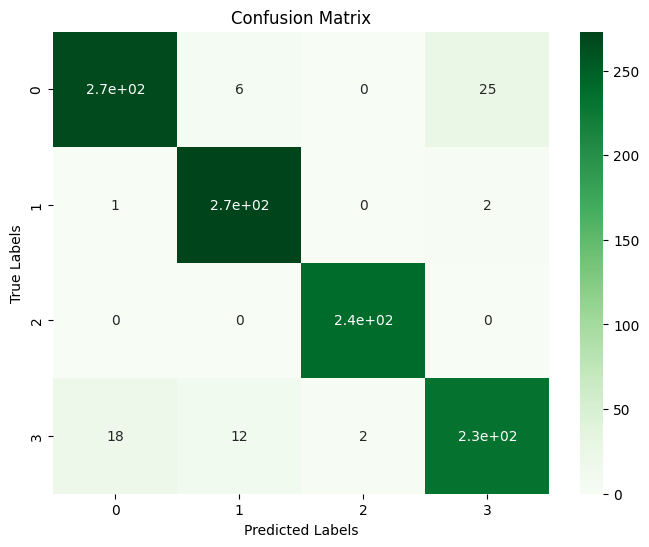

<Figure size 640x480 with 0 Axes>

In [18]:
# Menampilkan confusion matrix dalam bentuk grafik
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('save_model/confusion_matrix.jpg', format='jpg')